In [57]:
import numpy as np
import pandas as pd
from scipy.integrate import quad

In [58]:
def HestonCF(u, params, S0, r, T):
    kappa, theta, sigma_v, rho, v0 = params
    xi = sigma_v
    a = kappa * theta
    b = kappa
    d = np.sqrt((rho * xi * 1j * u - b)**2 + (u**2 + 1j*u) * xi**2)
    g = (b - rho * xi * 1j * u + d) / (b - rho * xi * 1j * u - d)
    exp_dT = np.exp(d * T)
    C = r * 1j * u * T + (a / xi**2) * ((b - rho * xi * 1j * u + d) * T - 2 * np.log((1 - g * exp_dT) / (1 - g)))
    D = ((b - rho * xi * 1j * u + d) / xi**2) * ((1 - exp_dT) / (1 - g * exp_dT))
    return np.exp(C + D * v0 + 1j * u * np.log(S0))

In [59]:
def integrand(u, params, S0, r, T, K, j):
    phi = HestonCF(u - (j-1)*1j, params, S0, r, T)
    numer = np.exp(-1j * u * np.log(K)) * phi
    return np.real(numer / (1j * u))

In [60]:
def HestonPrice_CF(S0, K, T, r, params):
    P1 = 0.5 + (1/np.pi) * quad(lambda u: integrand(u, params, S0, r, T, K, 1), 0, 100)[0]
    P2 = 0.5 + (1/np.pi) * quad(lambda u: integrand(u, params, S0, r, T, K, 2), 0, 100)[0]
    return S0 * P1 - K * np.exp(-r*T) * P2

In [61]:
def HestonPrice_QE(S0, K, T, r, params, M=50000, steps_per_year=25):
    kappa, theta, sigma_v, rho, v0 = params
    N = int(T * steps_per_year)
    dt = T / N
    S = np.full(M, S0)
    v = np.full(M, v0)
    for _ in range(N):
        Zv = np.random.randn(M)
        Zs = rho * Zv + np.sqrt(1 - rho**2) * np.random.randn(M)
        # Full-truncation Euler for variance
        v = np.maximum(v + kappa*(theta - np.maximum(v,0))*dt + sigma_v*np.sqrt(np.maximum(v,0))*np.sqrt(dt)*Zv, 0)
        S = S * np.exp((r - 0.5 * np.maximum(v,0)) * dt + np.sqrt(np.maximum(v,0) * dt) * Zs)
    payoff = np.maximum(S - K, 0)
    return np.exp(-r * T) * np.mean(payoff)

In [62]:
S0 = 100.0
r = 0.0
params = (2.0, 0.04, 0.30, -0.70, 0.04)

In [63]:
strikes = [80, 100, 120]
maturities = [1.0, 2.0, 3.0]

In [64]:
results = []
for T in maturities:
    for K in strikes:
        cf_price = HestonPrice_CF(S0, K, T, r, params)
        mc_price = HestonPrice_QE(S0, K, T, r, params, M=50000, steps_per_year=25)
        results.append({
            'Maturity (yrs)': T,
            'Strike': K,
            'CF Price': cf_price,
            'QE MC Price': mc_price
        })

df = pd.DataFrame(results).set_index(['Maturity (yrs)', 'Strike'])
df

CF Price  QE MC Price
Maturity (yrs) Strike                          
1.0            80     -3124.270003    12.902068
               100     -960.472032     2.710075
               120     3744.155802     0.182297
2.0            80     -2750.875139     8.982291
               100    -1076.749224     2.202178
               120     2264.206804     0.332566
3.0            80     -2637.712957     6.317060
               100    -1054.750570     1.838440
               120     1628.971290     0.361980

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import brentq

In [66]:
def bs_call_price(S0, K, T, r, sigma):
    from scipy.stats import norm
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [67]:
def implied_vol(target_price, S0, K, T, r):
    # Objective: bs_call_price(sigma) - target_price = 0
    f = lambda sigma: bs_call_price(S0, K, T, r, sigma) - target_price
    try:
        return brentq(f, 1e-6, 5.0)
    except ValueError:
        return np.nan

In [68]:
strikes = np.linspace(80, 100, 7)
maturities = np.linspace(1.0, 2, 7)
K_grid, T_grid = np.meshgrid(strikes, maturities)

In [69]:
CF_surface = np.zeros_like(K_grid)
MC_surface = np.zeros_like(K_grid)
IV_CF_surface = np.zeros_like(K_grid)
IV_MC_surface = np.zeros_like(K_grid)

In [70]:
for i in range(T_grid.shape[0]):
    for j in range(K_grid.shape[1]):
        K = K_grid[i, j]
        T = T_grid[i, j]
        cf_price = HestonPrice_CF(S0, K, T, r, params)
        mc_price = HestonPrice_QE(S0, K, T, r, params, M=20000, steps_per_year=25)
        CF_surface[i, j] = cf_price
        MC_surface[i, j] = mc_price
        IV_CF_surface[i, j] = implied_vol(cf_price, S0, K, T, r)
        IV_MC_surface[i, j] = implied_vol(mc_price, S0, K, T, r)

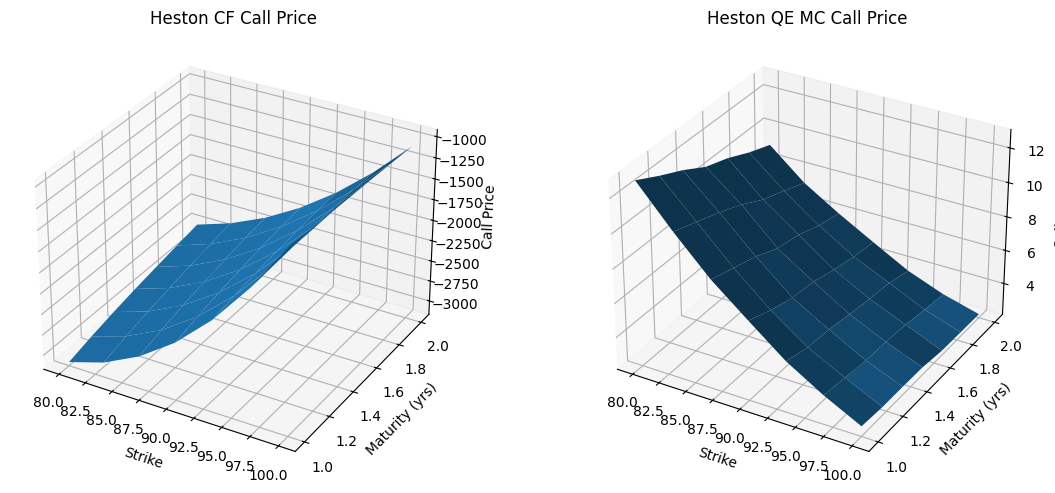

In [71]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(K_grid, T_grid, CF_surface, rstride=1, cstride=1)
ax1.set_title('Heston CF Call Price')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity (yrs)')
ax1.set_zlabel('Call Price')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(K_grid, T_grid, MC_surface, rstride=1, cstride=1)
ax2.set_title('Heston QE MC Call Price')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity (yrs)')
ax2.set_zlabel('Call Price')
plt.tight_layout()
plt.show()

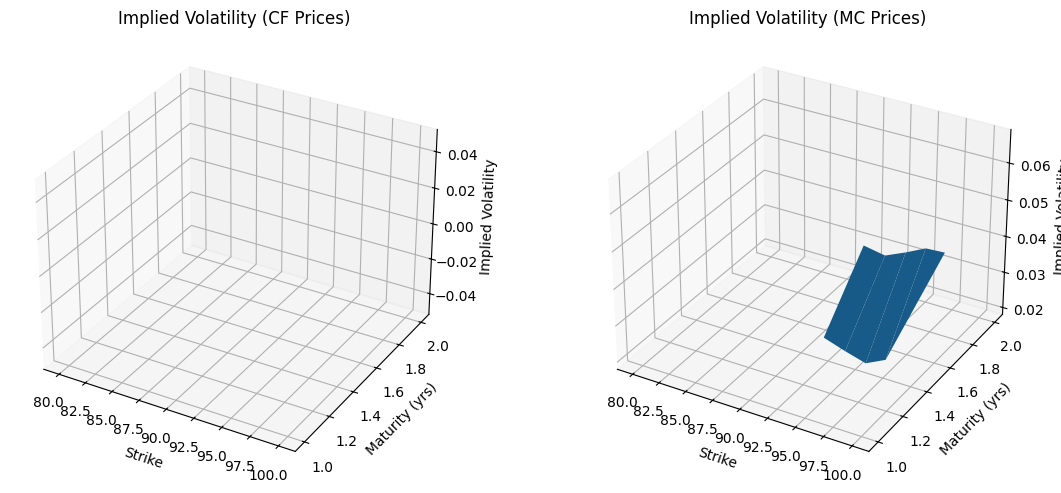

In [72]:
fig2 = plt.figure(figsize=(12, 5))
ax3 = fig2.add_subplot(121, projection='3d')
ax3.plot_surface(K_grid, T_grid, IV_CF_surface, rstride=1, cstride=1)
ax3.set_title('Implied Volatility (CF Prices)')
ax3.set_xlabel('Strike')
ax3.set_ylabel('Maturity (yrs)')
ax3.set_zlabel('Implied Volatility')

ax4 = fig2.add_subplot(122, projection='3d')
ax4.plot_surface(K_grid, T_grid, IV_MC_surface, rstride=1, cstride=1)
ax4.set_title('Implied Volatility (MC Prices)')
ax4.set_xlabel('Strike')
ax4.set_ylabel('Maturity (yrs)')
ax4.set_zlabel('Implied Volatility')

plt.tight_layout()
plt.show()